# Exploring Convolutional Layers Through Data and Experiments
## Fashion-MNIST Case Study

### Context and Motivation
In this project, neural networks are treated as architectural components rather than black boxes.
The goal is to understand how convolutional layers introduce inductive bias that improves learning
on image-based data.

Using the Fashion-MNIST dataset, we compare a baseline fully connected network against a
convolutional neural network (CNN), and perform controlled experiments to analyze the effect
of convolutional design choices.


In [ ]:
%pip install numpy matplotlib pandas torch scikit-learn

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split


In [8]:
# Load processed Fashion-MNIST CSV files
train_df = pd.read_csv("data/processed/fashion-mnist_train.csv")
test_df  = pd.read_csv("data/processed/fashion-mnist_test.csv")

train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

train_df["label"].value_counts().sort_index()


Training set shape: (19999, 785)
Test set shape: (10000, 785)


label
0    2064
1    2008
2    1961
3    2031
4    1952
5    1978
6    2007
7    2047
8    1970
9    1981
Name: count, dtype: int64

- Each sample contains 784 numerical pixel values (28×28 image)
- Labels range from 0 to 9 (10 clothing categories)
- Images are grayscale


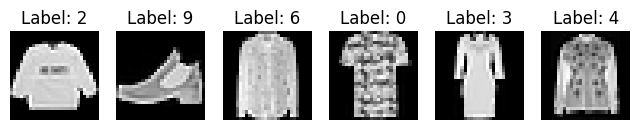

In [10]:
def show_samples(df, n=6):
    plt.figure(figsize=(8,3))
    for i in range(n):
        pixels = df.iloc[i, 1:].values.reshape(28, 28)
        label = df.iloc[i, 0]
        plt.subplot(1, n, i+1)
        plt.imshow(pixels, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

show_samples(train_df)


Preprocessing steps:
- Normalize pixel values to [0, 1]
- Reshape data for CNN input
- Convert labels to tensors


In [11]:
X_train = train_df.iloc[:, 1:].values / 255.0
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values

X_train.shape, X_test.shape


((19999, 784), (10000, 784))

In [12]:
class FashionMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx].reshape(1, 28, 28)  # 1 channel
        label = self.y[idx]
        return image, label


In [13]:
train_dataset = FashionMNISTDataset(X_train, y_train)
test_dataset  = FashionMNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)


In [14]:
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)


In [15]:
baseline_model = BaselineNN()
sum(p.numel() for p in baseline_model.parameters())


203530

In [16]:
def train_model(model, loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = []

    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    return history


In [17]:
baseline_history = train_model(baseline_model, train_loader)


Epoch 1: Loss = 0.6655
Epoch 2: Loss = 0.4684
Epoch 3: Loss = 0.4139
Epoch 4: Loss = 0.3781
Epoch 5: Loss = 0.3575


In [18]:
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [19]:
cnn_model = FashionMNISTCNN()
sum(p.numel() for p in cnn_model.parameters())


421642

In [20]:
cnn_history = train_model(cnn_model, train_loader)


Epoch 1: Loss = 0.6354
Epoch 2: Loss = 0.3945
Epoch 3: Loss = 0.3339
Epoch 4: Loss = 0.2972
Epoch 5: Loss = 0.2715


Experiment:
- Compare kernel size 3×3 vs 5×5
- Keep all other parameters fixed


In [21]:
class CNNKernel5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 14 * 14, 10)
        )

    def forward(self, x):
        return self.fc(self.conv(x))


In [22]:
cnn_k5 = CNNKernel5()
train_model(cnn_k5, train_loader)


Epoch 1: Loss = 0.5604
Epoch 2: Loss = 0.3707
Epoch 3: Loss = 0.3251
Epoch 4: Loss = 0.2911
Epoch 5: Loss = 0.2741


[0.560366908439432,
 0.3706761335317319,
 0.325106648877025,
 0.29107422448290043,
 0.274073455304193]

### Why did convolutional layers outperform the baseline?
Convolutional layers exploit spatial locality and weight sharing, reducing the number of parameters
while preserving spatial structure.

### What inductive bias does convolution introduce?
Translation invariance and local feature extraction.

### When is convolution not appropriate?
For non-spatial data such as tabular business metrics or symbolic data.


In [24]:
# Save trained CNN model
torch.save(cnn_model.state_dict(), "model.pth")
print("Model saved as model.pth")


Model saved as model.pth


This experiment demonstrates that convolutional layers are not merely performance optimizations,
but architectural components that encode domain assumptions.

Understanding these assumptions is critical for designing robust and explainable AI systems
in enterprise environments.


In [ ]:
import tarfile
import os

model_dir = "model"
output_path = "model.tar.gz"

with tarfile.open(output_path, "w:gz") as tar:
    tar.add(os.path.join(model_dir, "model.pth"), arcname="model.pth")
    tar.add(os.path.join(model_dir, "inference.py"), arcname="inference.py")

print("model.tar.gz creado")


model.tar.gz creado correctamente
